<a href="https://colab.research.google.com/github/shpotes/traffic-counter/blob/master/notebooks/dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


#◢ Verify Correct Runtime Settings

**<font color='#FF000'> IMPORTANT </font>**

In the "Runtime" menu for the notebook window, select "Change runtime type." Ensure that the following are selected:
* Runtime Type = Python 3
* Hardware Accelerator = GPU 


#◢ Git clone and install Fast R-CNN

In [2]:
!git clone https://github.com/shpotes/traffic-counter
%cd traffic-counter/notebooks

Cloning into 'traffic-counter'...
remote: Enumerating objects: 790, done.
remote: Counting objects: 100% (790/790), done.
remote: Compressing objects: 100% (745/745), done.
remote: Total 790 (delta 66), reused 721 (delta 32), pack-reused 0
Receiving objects: 100% (790/790), 32.99 MiB | 39.01 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/traffic-counter/notebooks


#◢ Setup

In [0]:
#!pip install -r ../requirements.txt

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import os
import warnings

from typing import List, Tuple

warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
tf.__version__

'1.14.0'

#◢ Region Proposal Network

### Load minimal example

In [0]:
train = pd.read_csv('../data/metadata.csv')
example = train[:11][['xmin', 'ymin', 'xmax', 'ymax']]
example = example.values
example[:, [0, 2]] = np.round(example[:, [0, 2]] * 244/704) # fix square size
example[:, [1, 3]] = np.round(example[:, [1, 3]] * 244/480)

#◢ RPN 
* Generate anchor boxes
  + Generate $A$ anchor boxes centred at cell $i$
  + "Move" anchors.
* Choose positive vs negative examples
  + Compute iou
  + Assign a positive label to:
    * The anchor with the highest IoU overlap with a ground-truth-box
    * An anchor that has an IoU overlap higher than 0.7 with ground-truth box.
  + Assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes.
* Hierarchical Sampling
  + Each mini-batch arises from a single image.
  + randomly sample $N$ anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to 1:1.
  + If there are fewer than $N/2$ positive samples in an image, pad the mini-batch with negative ones

##◢ Anchor boxes
#### Generate anchor boxes
Exactly [this](https://github.com/facebookresearch/Detectron/blob/master/detectron/modeling/generate_anchors.py)

In [0]:
import sys
sys.path.append("..")


from vehicle_nowcasting.data.generate_anchors import generate_anchors 

In [0]:
def plot_anchors(img: np.ndarray, anch: np.ndarray,
                 color: Tuple[int, int, int],
                 size: int = 1) -> np.ndarray:
    for i in range(len(anch)):
        img = cv2.rectangle(img, (anch[i, 0], anch[i, 1]), 
                                    (anch[i, 2], anch[i, 3]), color, size)                
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 999.5, 999.5, -0.5)

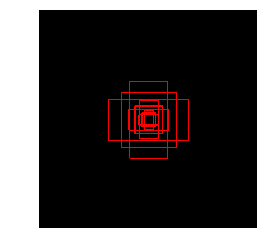

In [10]:
img = np.zeros((1000, 1000, 3))
a = generate_anchors() / 2 + [500, 500, 500, 500]
img = plot_anchors(img, a.astype(int) , (255, 0, 0), 4)
plt.imshow(img)
plt.axis('off')

### "Move" anchors.
trivial

In [14]:
# Naive idea

move_anchors = lambda x, dx, dy: x + [dx, dy, dx, dy]


for dx in range(25):
    for dy in range(25):
        anchors = generate_anchors(base_size=4, 
                                   ratios=[1, 1.25, 1.5, 1.75, 2, 2.25, 2.5],
                                   scales=2 ** np.arange(3, 10))
        anchors = move_anchors(anchors.astype(int), 20 * dx, 20 * dy)
        
anchors.shape

(49, 4)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML, Image

rc('animation', html='html5')

In [0]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
plt.axis('off')

a = np.zeros((1000, 1000, 3))

im = plt.imshow(a)

def init():
    im.set_data(np.zeros((1000, 1000, 3)))
    return [im]

# animation function.  This is called sequentially
def animate(flush, i):
    a = np.zeros((1000, 1000, 3)) if flush else im.get_array()
    b = (generate_anchors() / 2) + [(i % 4 + 1) * 200, np.ceil((i + 1) / 4) * 200,
                                    (i % 4 + 1) * 200, np.ceil((i + 1) / 4) * 200]
    a = plot_anchors(a, b.astype(int) , (255, 0, 0), 4)
    im.set_array(a)
    return [im]

def anim(flush):
    return animation.FuncAnimation(fig, lambda x: animate(flush, x), init_func=init,
                                frames=16, interval=1000, blit=True);
plt.close()

In [17]:
anim(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [20]:
# Just try to vectorize the previews idea
from itertools import product

delta = 10 * np.array(list(product(range(30),range(30))))
delta = np.hstack([delta, delta])
 
anchors = generate_anchors(base_size=4,
                           ratios=[1, 1.25, 1.5, 1.75, 2, 2.25, 2.5],
                           scales=2 ** np.arange(3, 10)) 

print(delta.shape, anchors.shape)
anchors = anchors.reshape(-1, 4, 1) + np.zeros((*anchors.shape, delta.shape[0]))
anchors += delta.T.reshape(1, 4, -1)
print(anchors.shapeb)

(900, 4) (49, 4)
(49, 4, 900)


In [23]:
# There are several ways to improve the code
dx = 10 * np.arange(3)
dy = 10 * np.arange(3)

# Vectorized version of itertools.product
delta = np.transpose([np.tile(dx, len(dy)), np.repeat(dy, len(dx))])
delta

array([[ 0,  0],
       [10,  0],
       [20,  0],
       [ 0, 10],
       [10, 10],
       [20, 10],
       [ 0, 20],
       [10, 20],
       [20, 20]])

In [0]:
# anchors on grid

dx = 10 * np.arange(30)
dy = 10 * np.arange(30)

delta = np.transpose([np.tile(dx, len(dy)), np.repeat(dy, len(dx))])
delta = np.hstack([delta, delta])
anchors = generate_anchors(base_size=4,
                           ratios=[1, 1.25, 1.5, 1.75, 2, 2.25, 2.5],
                           scales=2 ** np.arange(3, 10))

anchors = anchors.reshape(-1, 4, 1) + np.zeros((*anchors.shape, delta.shape[0]))
anchors += delta.T.reshape(1, 4, -1)
anchors = anchors.transpose(2, 0, 1).reshape(-1, 4)

##◢ Choose positive vs negative examples

In [0]:
def iou(bboxes1: np.ndarray, bboxes2: np.ndarray) -> np.ndarray:
  """
  citation needed
  """
  x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
  x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    
  xA = np.maximum(x11, np.transpose(x21))
  yA = np.maximum(y11, np.transpose(y21))
  xB = np.minimum(x12, np.transpose(x22))
  yB = np.minimum(y12, np.transpose(y22))
    
  interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    
  boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
  boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    
  iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    
  return iou

In [0]:
# ignore anchors outsite image
anchors = anchors[((anchors > 0) & (anchors < 244)).all(axis=-1), :]

In [0]:
# define postive and negative examples
iou_matrix = iou(anchors, example)
pos = anchors[(iou_matrix > 0.7).any(axis=1)]
neg = anchors[(iou_matrix < 0.3).any(axis=1)]

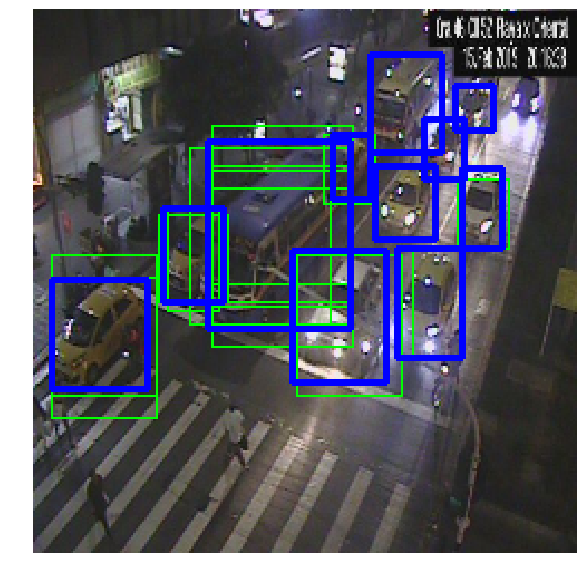

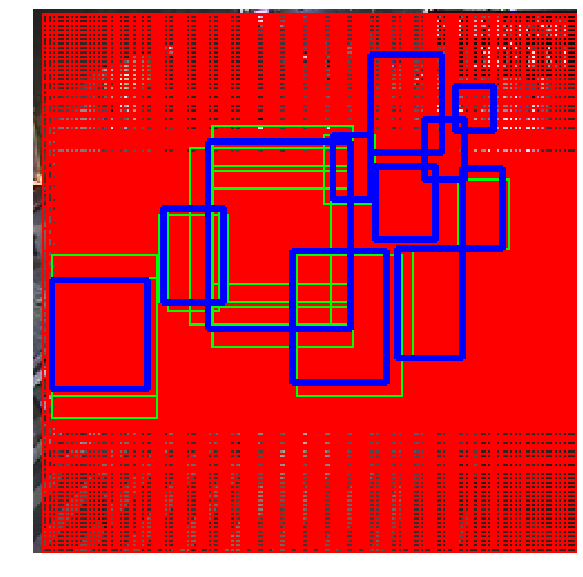

In [30]:
img = cv2.cvtColor(cv2.imread('../data/train/15-02-15-20:17.jpg'), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (244, 244)) 

def plot_bb(img, org, color, size):
    for anch in org.astype(int):
        img = cv2.rectangle(img, (anch[0], anch[1]), 
                            (anch[2], anch[3]), color, size)
    return img

img = plot_bb(img, pos, (0, 255, 0), 1)
img = plot_bb(img, example, (0, 0, 255), 2)
        
plt.figure(figsize=(10, 10))
plt.imshow(img/255)
plt.axis('off')
plt.show()

img = plot_bb(img, neg, (255, 0, 0), 1)
img = plot_bb(img, pos, (0, 255, 0), 1)
img = plot_bb(img, example, (0, 0, 255), 2)
plt.figure(figsize=(10, 10))
plt.imshow(img/255)
plt.axis('off')
plt.show()